
Theo Algoud,
Luca Boscolo Camiletto,
Ivana Jasna Caltagirone,
Arianna Sammarchi

In [1]:
# Importing needed packages, libraries and funcitons.
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from keras.optimizers import SGD
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout, Activation
from keras import regularizers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as img
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#### Useful functions
Defining funcitons that will be used recurrently in the code

In [2]:
#Function to plot a set of images.
def plotter(array):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        if i < len(array):
            ax.imshow(array[i])
    plt.show()

In [3]:
#Function to build an array of labels from a directory.
def label_array_builder(folder):
    labels = []
    for filename in os.listdir(folder):
        name = filename.rstrip('0123456789.jpg')
        labels.append(name) 
    return np.array(labels)

In [4]:
#Function to build an array of images from a directory.
def image_array_builder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        image = Image.open(img_path)
        images.append(image)
    return np.array(images)

In [5]:
#Function to resize the images in the array.
def resizer(array, size):
    result = [np.array(i.resize(size)) for i in array]
    return np.array(result)

# EDA and Data Preprocessing

### Loading data

In [6]:
labels_str = label_array_builder(r"C:\Users\Ivana\ML_exam\Garbage classification")

#Encoding labels
l = LabelEncoder()
labels = l.fit_transform(labels_str)

In [7]:
#Loading images
images = image_array_builder(r"C:\Users\Ivana\ML_exam\Garbage classification")

<ipython-input-4-de3e9e5d0586>:8: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(images)
<ipython-input-4-de3e9e5d0586>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images)


### Data Resizing

Creating two separate dataset sizes for the different algorithms.

In [8]:
#Size 224x224 for ResNet-50 and other algorithms.
size_224 = (224, 224, 3)
resized_images_224 = resizer(images, size_224[0:2])

In [9]:
#Size 227x227 for AlexNet
size_227 = (227, 227, 3)
resized_images_227 = resizer(images, size_227[0:2])

### Splitting Data

224x224

In [10]:
# Shuffle the dataset
resized_images_224, labels = shuffle(resized_images_224, labels, random_state=42)

#Splitting the data with an 70/20/10 split
x_train_val, x_test_224, y_train_val, y_test_224 = train_test_split(resized_images_224, labels, test_size=0.2, random_state=42)
x_train_224, x_val_224, y_train_224, y_val_224 = train_test_split(x_train_val, y_train_val, test_size=0.111, random_state=42)

print(x_train_224.shape)
print(x_test_224.shape)
print(x_val_224.shape)

(1796, 224, 224, 3)
(506, 224, 224, 3)
(225, 224, 224, 3)


227x227

In [11]:
# Shuffle the dataset
resized_images_227, labels = shuffle(resized_images_227, labels, random_state=42)

#Splitting the data with an 70/20/10 split
x_train_val, x_test_227, y_train_val, y_test_227 = train_test_split(resized_images_227, labels, test_size=0.2, random_state=42)
x_train_227, x_val_227, y_train_227, y_val_227 = train_test_split(x_train_val, y_train_val, test_size=0.111, random_state=42)

print(x_train_227.shape)
print(x_test_227.shape)
print(x_val_227.shape)

(1796, 227, 227, 3)
(506, 227, 227, 3)
(225, 227, 227, 3)


#### Pixel distribution of training set

In [12]:
#Funciton to plot the pixel distribution of the generatet trining sets.
def plot_pixel_intensity_distribution(x_train):
    label_mapping = {0: "cardboard", 1: "glass", 2: "metal", 3: "paper", 4: "plastic", 5: "trash"}
    # Set a fixed random seed
    np.random.seed(42)

    # Flatten the pixel intensities of all images in the training set
    flatten_images_train = [np.array(image).flatten() for image in x_train]

    # Plot histograms
    plt.figure(figsize=(10, 6))
    for i in range(6):
        class_label = label_mapping[i]  # Get the class label name from the dictionary
        plt.hist(flatten_images_train[i], bins=256, alpha=0.5, label=class_label)

    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Pixel Intensity Distribution in Training Set")
    plt.legend()
    plt.show()

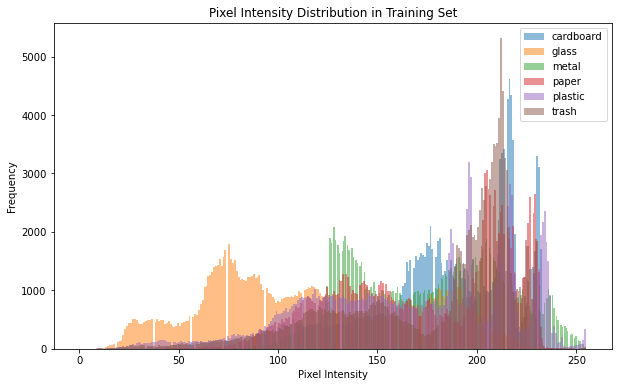

In [13]:
plot_pixel_intensity_distribution(x_train_224)

#### Sample for each class before augmentation

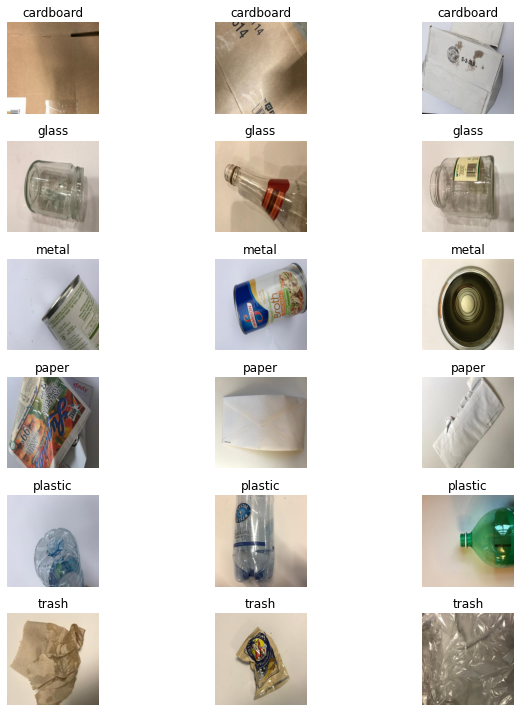

In [14]:
label_mapping = {0: "cardboard", 1: "glass", 2: "metal", 3: "paper", 4: "plastic", 5: "trash"}
num_samples = 3
sample_images = []
sample_labels = []
for label in label_mapping.keys():
    indices = np.where(y_train_224 == label)[0]
    sample_indices = indices[:num_samples]
    sample_images.extend([x_train_224[i] for i in sample_indices])
    sample_labels.extend([y_train_224[i] for i in sample_indices])

num_classes = len(label_mapping)
fig, axes = plt.subplots(num_classes, num_samples, figsize=(10, 10))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        image_index = i * num_samples + j
        ax.imshow(sample_images[image_index])
        ax.axis('off')
        ax.set_title(label_mapping[sample_labels[image_index]])

plt.tight_layout()
plt.show()

### Data Augmentation

In [15]:
#Counting entries for each label before augmentation
label_counts = pd.Series(y_train_224).value_counts()

for label, count in label_counts.items():
    print("Label {}: {} entries".format(label, count))

Label 3: 438 entries
Label 1: 346 entries
Label 4: 345 entries
Label 2: 291 entries
Label 0: 288 entries
Label 5: 88 entries


In [16]:
#Defining funciton for data augmentation
def augment_data(x_train, y_train, num_augmented_images, batch_size):
    data_augmentation = ImageDataGenerator(rotation_range=15, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, fill_mode='nearest')
    #Creating a generator for augmented images from the training set
    augmented_data_generator = data_augmentation.flow(x_train, y_train, batch_size=batch_size, shuffle=True)

    augmented_images_list = []
    augmented_labels_list = []

    #Generating augmented images and labels in batches
    num_batches = num_augmented_images // batch_size
    remaining_images = num_augmented_images % batch_size

    for i in range(num_batches):
        #Generating a batch of augmented images
        augmented_images, augmented_labels = next(augmented_data_generator, batch_size)

        #Appending the augmented images and labels to the lists
        augmented_images_list.append(augmented_images)
        augmented_labels_list.append(augmented_labels)

    #Generating the remaining augmented images if any
    if remaining_images > 0:
        augmented_images, augmented_labels = next(augmented_data_generator, remaining_images)
        augmented_images_list.append(augmented_images)
        augmented_labels_list.append(augmented_labels)

    augmented_images = np.concatenate(augmented_images_list, axis=0)
    augmented_labels = np.concatenate(augmented_labels_list, axis=0)
    x_train = np.concatenate((x_train, augmented_images), axis=0)
    y_train = np.concatenate((y_train, augmented_labels), axis=0)
    x_train, y_train = shuffle(x_train, y_train, random_state=42)

    return x_train, y_train

224x224

In [17]:
x_train_224, y_train_224 = augment_data(x_train_224, y_train_224, num_augmented_images = 500, batch_size = 32)

227x227

In [18]:
x_train_227, y_train_227 = augment_data(x_train_227, y_train_227, num_augmented_images = 500, batch_size = 32)

In [19]:
#Counting entries for each label after augmentation
label_counts = pd.Series(y_train_224).value_counts()

for label, count in label_counts.items():
    print("Label {}: {} entries".format(label, count))

Label 3: 558 entries
Label 1: 453 entries
Label 4: 441 entries
Label 2: 374 entries
Label 0: 369 entries
Label 5: 113 entries


### Data Normalization

In [20]:
#Defining function to normalize the training datasets
def normalizer(array):
    result = [np.asarray(i)/255 for i in array]
    return np.asarray(result)

In [21]:
x_train_224_norm = normalizer(x_train_224)

### Oversampling with SMOTE

In [22]:
#Defining function to plot the class distribution
def plot_class_distribution(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.bar(unique_labels, counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

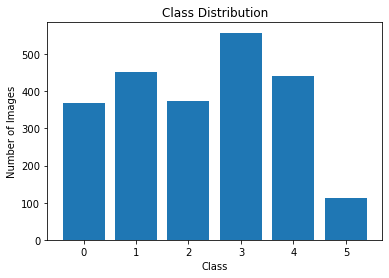

In [23]:
plot_class_distribution(y_train_224)

In [24]:
#Defining function to perform SMOTE on train and adapting labels
def apply_smote_oversampling(x_train, y_train):
    #Reshaping the input array to 2D
    train_array_2d = x_train.reshape(x_train.shape[0], -1)
    #Applying SMOTE oversampling to the flattened array
    smote = SMOTE()
    x_train_smote, y_train_smote = smote.fit_resample(train_array_2d, y_train)
    #Reshaping the balanced array to original dimensions
    x_train_smote = x_train_smote.reshape(x_train_smote.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3])
    return x_train_smote, y_train_smote

In [25]:
x_train_224_norm_smote, y_train_224_norm_smote = apply_smote_oversampling(x_train_224_norm, y_train_224)

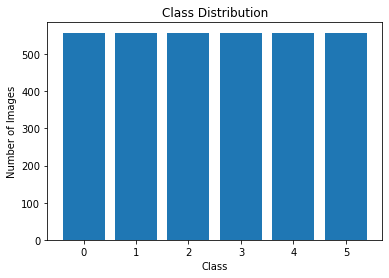

In [26]:
plot_class_distribution(y_train_224_norm_smote)

# Random Forest
### With and without SMOTE

In [27]:
# Function to merge data
def merge_data(x_train, x_val, y_train, y_val):
    x_train_merged = np.vstack((x_train, x_val))
    y_train_merged = np.concatenate((y_train, y_val), axis=0)
    return x_train_merged, y_train_merged

# Function to flatten data
def flatten_data(data):
    return data.reshape(data.shape[0], -1)

# Function to train random forest
def train_random_forest(x_train, y_train):
    random_forest = RandomForestClassifier(n_estimators=100)
    random_forest.fit(x_train, y_train)
    return random_forest

# Function to evaluate the model
def evaluate_model(model, x_test, y_test):
    predictions = model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro', zero_division=1)
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    return accuracy, precision, recall, f1

In [28]:
# Merge x_train, x_val, y_train, and y_val
x_train_merged, y_train_merged = merge_data(x_train_224_norm, x_val_224, y_train_224, y_val_224)

# Flatten the merged training data
train_merged_flat = flatten_data(x_train_merged)

# Train the Random Forest on the merged training data
random_forest = train_random_forest(train_merged_flat, y_train_merged)

# Reshape x_test
num_test_samples = x_test_224.shape[0]
test_array_flat = flatten_data(x_test_224)

# Evaluate the model on the test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(random_forest, test_array_flat, y_test_224)

# Print the accuracy measures
print("Random Forest - Test Accuracy:", test_accuracy)
print("Random Forest - Test Precision:", test_precision)
print("Random Forest - Test Recall:", test_recall)
print("Random Forest - Test F1 Score:", test_f1)

# Merge x_train_smote, x_val, y_train_smote, and y_val
x_train_merged_smote, y_train_merged_smote = merge_data(x_train_224_norm_smote, x_val_224, y_train_224_norm_smote, y_val_224)

# Flatten the merged training data
train_merged_flat_smote = flatten_data(x_train_merged_smote)

# Train the Random Forest on the merged training data
random_forest_smote = train_random_forest(train_merged_flat_smote, y_train_merged_smote)

# Evaluate the model on the test data
test_accuracy_smote, test_precision_smote, test_recall_smote, test_f1_smote = evaluate_model(random_forest_smote, test_array_flat, y_test_224)

# Print the accuracy measures
print("Random Forest with SMOTE - Test Accuracy:", test_accuracy_smote)
print("Random Forest with SMOTE - Test Precision:", test_precision_smote)
print("Random Forest with SMOTE - Test Recall:", test_recall_smote)
print("Random Forest with SMOTE - Test F1 Score:", test_f1_smote)

Random Forest - Test Accuracy: 0.5889328063241107
Random Forest - Test Precision: 0.6145155628349578
Random Forest - Test Recall: 0.5679808097169208
Random Forest - Test F1 Score: 0.5693002295919238
Random Forest with SMOTE - Test Accuracy: 0.5711462450592886
Random Forest with SMOTE - Test Precision: 0.6098784431133218
Random Forest with SMOTE - Test Recall: 0.5571841270452382
Random Forest with SMOTE - Test F1 Score: 0.5517312641389545


# SVM + PCA
### With and without SMOTE 

In [29]:
def compute_pca(data):
    num_samples = data.shape[0]
    height, width, channels = data.shape[1:]
    flattened_data = data.reshape(num_samples, height * width * channels)

    pca = PCA(n_components=0.99)  # Set the desired variance (99% in this case)
    reduced_data = pca.fit_transform(flattened_data)

    optimal_num_components = reduced_data.shape[1]
    variance_retained = sum(pca.explained_variance_ratio_) * 100

    return reduced_data, optimal_num_components, variance_retained

def train_and_evaluate_svm(train_data, train_labels, test_data, test_labels):
    svm = SVC(probability=True)
    svm.fit(train_data, train_labels)

    test_predictions = svm.predict(test_data)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_precision = precision_score(test_labels, test_predictions, average='macro', zero_division=1)
    test_recall = recall_score(test_labels, test_predictions, average='macro')
    test_f1 = f1_score(test_labels, test_predictions, average='macro')

    return test_accuracy, test_precision, test_recall, test_f1

In [30]:
# Merge the training and validation data using merge_data() function 
x_train_val_merged, y_train_val_merged = merge_data(x_train_224_norm, x_val_224, y_train_224, y_val_224)
x_train_val_merged_smote, y_train_val_merged_smote = merge_data(x_train_224_norm_smote, x_val_224, y_train_224_norm_smote, y_val_224)


# Compute PCA for both x_train and x_train_smote
x_train_reduced, optimal_num_components_train, variance_retained_train = compute_pca(x_train_val_merged)
x_train_smote_reduced, optimal_num_components_train_smote, variance_retained_train_smote = compute_pca(
    x_train_val_merged_smote
)

# Define height, width, and channels for reshaping the test data
height, width, channels = x_test_224.shape[1:]

# Reshape the test data to have 2 dimensions
num_test_samples = x_test_224.shape[0]
test_array_flat = x_test_224.reshape(num_test_samples, height * width * channels)

# Perform PCA on the test data for x_train
num_train_samples = x_train_val_merged.shape[0]
pca = PCA(n_components=optimal_num_components_train)
flattened_data = flatten_data(x_train_val_merged)
pca.fit(flattened_data)
test_array_flat_pca_train = pca.transform(test_array_flat)

# Perform PCA on the test data for x_train_smote
num_train_smote_samples = x_train_val_merged_smote.shape[0]
pca = PCA(n_components=optimal_num_components_train_smote)
flattened_data_smote = flatten_data(x_train_val_merged_smote)
pca.fit(flattened_data_smote)
test_array_flat_pca_train_smote = pca.transform(test_array_flat)

# Train and evaluate SVM on x_train
test_accuracy_train, test_precision_train, test_recall_train, test_f1_train = train_and_evaluate_svm(
    x_train_reduced, y_train_val_merged, test_array_flat_pca_train, y_test_224
)
# Train and evaluate SVM on x_train_smote
test_accuracy_train_smote, test_precision_train_smote, test_recall_train_smote, test_f1_train_smote = train_and_evaluate_svm(
    x_train_smote_reduced, y_train_val_merged_smote, test_array_flat_pca_train_smote, y_test_224
)

In [32]:
print("Without SMOTE:")
print("Optimal Number of Components:", optimal_num_components_train)
print("Variance Retained:", variance_retained_train)
print("SVM Test Accuracy:", test_accuracy_train)
print("SVM Test Precision:", test_precision_train)
print("SVM Test Recall:", test_recall_train)
print("SVM Test F1 Score:", test_f1_train)

print("\nWith SMOTE:")
print("Optimal Number of Components:", optimal_num_components_train_smote)
print("Variance Retained:", variance_retained_train_smote)
print("SVM Test Accuracy:", test_accuracy_train_smote)
print("SVM Test Precision:", test_precision_train_smote)
print("SVM Test Recall:", test_recall_train_smote)
print("SVM Test F1 Score:", test_f1_train_smote)

Without SMOTE:
Optimal Number of Components: 65
Variance Retained: 99.00041405344382
SVM Test Accuracy: 0.4901185770750988
SVM Test Precision: 0.6049320705066362
SVM Test Recall: 0.4539717640412085
SVM Test F1 Score: 0.4469271166998141

With SMOTE:
Optimal Number of Components: 64
Variance Retained: 99.0069841966033
SVM Test Accuracy: 0.5039525691699605
SVM Test Precision: 0.5633487811297114
SVM Test Recall: 0.4748212070434292
SVM Test F1 Score: 0.4720981341137483


# Convolutional Neural Networks

In [15]:
#Defining a function to plot the accuracy and loss for each epoch
def epoch_plot(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### AlexNet Model
#### with BatchNorm and Dropout layers

In [34]:
# AlexNet architecture
model1 = models.Sequential()
model1.add(layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=size_227))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model1.add(layers.Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model1.add(layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(4096, activation='relu'))
model1.add(Dropout(0.4))
model1.add(layers.Dense(4096, activation='relu'))
model1.add(layers.Dense(6, activation='softmax'))

model1.load_weights('AlexNet_weights.h5')

# Compiling the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
#Defining early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

#Fitting the model
history = model1.fit(x_train_227, to_categorical(y_train_227), validation_data=(x_val_227, to_categorical(y_val_227)), epochs=20,batch_size=64, callbacks=early_stop)

model1.summary()

Epoch 1/20
37/37 [==============================] - 148s 4s/step - loss: 12.1443 - accuracy: 0.3349 - val_loss: 611.2924 - val_accuracy: 0.1244
Epoch 2/20
37/37 [==============================] - 160s 4s/step - loss: 1.7754 - accuracy: 0.4870 - val_loss: 57.5138 - val_accuracy: 0.1956
Epoch 3/20
37/37 [==============================] - 145s 4s/step - loss: 1.8638 - accuracy: 0.4671 - val_loss: 19.3239 - val_accuracy: 0.1956
Epoch 4/20
37/37 [==============================] - 128s 3s/step - loss: 1.4473 - accuracy: 0.4801 - val_loss: 7.4951 - val_accuracy: 0.1022
Epoch 5/20
37/37 [==============================] - 114s 3s/step - loss: 1.2780 - accuracy: 0.5308 - val_loss: 7.5671 - val_accuracy: 0.2000
Epoch 6/20
37/37 [==============================] - 115s 3s/step - loss: 1.1508 - accuracy: 0.5797 - val_loss: 3.2650 - val_accuracy: 0.1733
Epoch 7/20
37/37 [==============================] - 113s 3s/step - loss: 1.1180 - accuracy: 0.6005 - val_loss: 2.6200 - val_accuracy: 0.2667
Epoch 8/

In [37]:
#model1.save_weights('AlexNet_weights.h5')

16/16 [==============================] - 9s 534ms/step


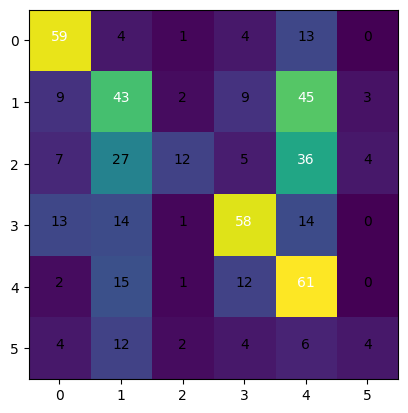

16/16 [==============================] - 9s 551ms/step - loss: 1.4939 - accuracy: 0.4684
              precision    recall  f1-score   support

     Class 0       0.63      0.73      0.67        81
     Class 1       0.37      0.39      0.38       111
     Class 2       0.63      0.13      0.22        91
     Class 3       0.63      0.58      0.60       100
     Class 4       0.35      0.67      0.46        91
     Class 5       0.36      0.12      0.19        32

    accuracy                           0.47       506
   macro avg       0.50      0.44      0.42       506
weighted avg       0.51      0.47      0.44       506

Test loss: 1.4939154386520386
Test accuracy: 0.4683794379234314


In [36]:
y_pred = model1.predict(x_test_227)

# Convert the predictions from one-hot encoded format to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

#Computing the confusion matrix
conf_matrix = confusion_matrix(y_test_227, y_pred_classes)
plt.imshow(conf_matrix)

thresh = conf_matrix.max() / 2.
for i in range(6):
    for j in range(6):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()
test_loss, test_acc = model1.evaluate(x_test_227, to_categorical(y_test_227))

#Printing the classification report
y_pred_classes = np.argmax(y_pred, axis=1)
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
print(classification_report(y_test_227, y_pred_classes, target_names=target_names))

#Printing accuracy and loss on the test set
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

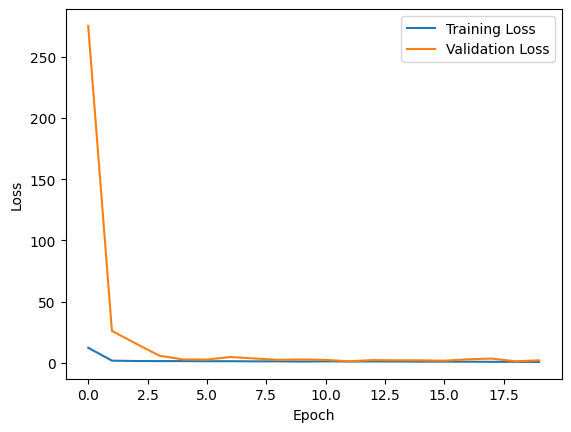

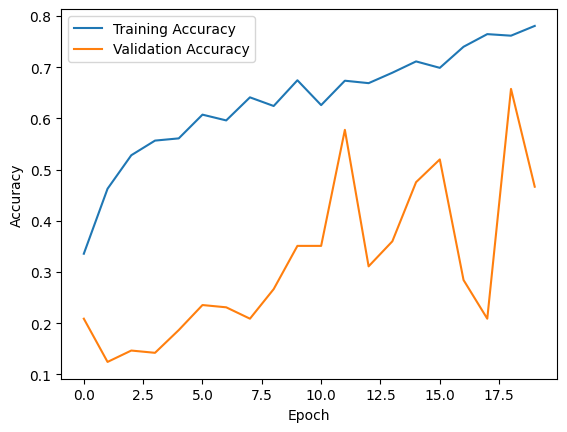

In [18]:
epoch_plot(history)

### ResNet-50
#### with L2 Regularization and Transfer Learning

In [51]:
#Loading the ResNet50 model with pre-trained weights on ImageNet
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=size_224)

#Freezing the layers so that they are not updated during training
for layer in resnet.layers:
    layer.trainable = False

# Adding a new top layer for classification and a dense layer with L2 regularization
x = Flatten()(resnet.output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

# Create a new model with ResNet50 base and custom top layers
model2 = Model(inputs=resnet.input, outputs=predictions)

model2.load_weights('ResNet50_weights.h5')

# Compile the model with a lower learning rate and a custom optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)

# Train the model using a small learning rate for the custom top layers
history = model2.fit(x_train_224, to_categorical(y_train_224), validation_data=(x_val_224, to_categorical(y_val_224)), epochs=20, batch_size=64)

model2.summary()

Epoch 1/20
37/37 [==============================] - 216s 6s/step - loss: 1.9694 - accuracy: 0.6304 - val_loss: 1.1403 - val_accuracy: 0.7600
Epoch 2/20
37/37 [==============================] - 197s 5s/step - loss: 0.8167 - accuracy: 0.8826 - val_loss: 1.2133 - val_accuracy: 0.7644
Epoch 3/20
37/37 [==============================] - 199s 5s/step - loss: 0.6645 - accuracy: 0.9268 - val_loss: 1.1092 - val_accuracy: 0.8133
Epoch 4/20
37/37 [==============================] - 201s 5s/step - loss: 0.6047 - accuracy: 0.9445 - val_loss: 1.1655 - val_accuracy: 0.8000
Epoch 5/20
37/37 [==============================] - 195s 5s/step - loss: 0.5448 - accuracy: 0.9601 - val_loss: 1.0723 - val_accuracy: 0.8089
Epoch 6/20
37/37 [==============================] - 210s 6s/step - loss: 0.5058 - accuracy: 0.9740 - val_loss: 1.1201 - val_accuracy: 0.8444
Epoch 7/20
37/37 [==============================] - 192s 5s/step - loss: 0.4896 - accuracy: 0.9762 - val_loss: 1.0993 - val_accuracy: 0.8356
Epoch 8/20
37

In [ ]:
#model2.save_weights('ResNet50_weights.h5')

16/16 [==============================] - 43s 3s/step


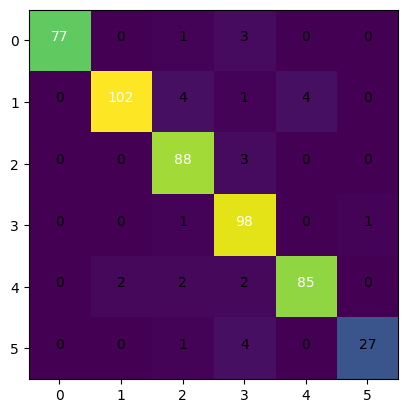

16/16 [==============================] - 48s 3s/step - loss: 0.6092 - accuracy: 0.9427
              precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        81
     Class 1       0.98      0.92      0.95       111
     Class 2       0.91      0.97      0.94        91
     Class 3       0.88      0.98      0.93       100
     Class 4       0.96      0.93      0.94        91
     Class 5       0.96      0.84      0.90        32

    accuracy                           0.94       506
   macro avg       0.95      0.93      0.94       506
weighted avg       0.95      0.94      0.94       506

Test loss: 0.6092089414596558
Test accuracy: 0.9426877498626709


In [52]:
y_pred = model2.predict(x_test_224)

# Convert the predictions from one-hot encoded format to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

#Computing the confusion matrix
conf_matrix = confusion_matrix(y_test_224, y_pred_classes)
plt.imshow(conf_matrix)

thresh = conf_matrix.max() / 2.
for i in range(6):
    for j in range(6):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()
test_loss, test_acc = model2.evaluate(x_test_224, to_categorical(y_test_224))

#Printing the classification report
y_pred_classes = np.argmax(y_pred, axis=1)
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
print(classification_report(y_test_224, y_pred_classes, target_names=target_names))

#Printing accuracy and loss on the test set
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

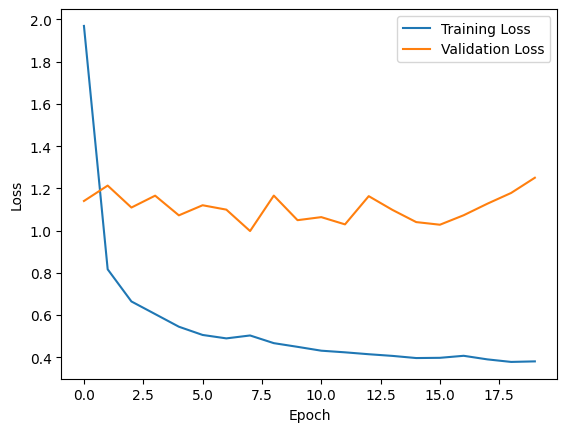

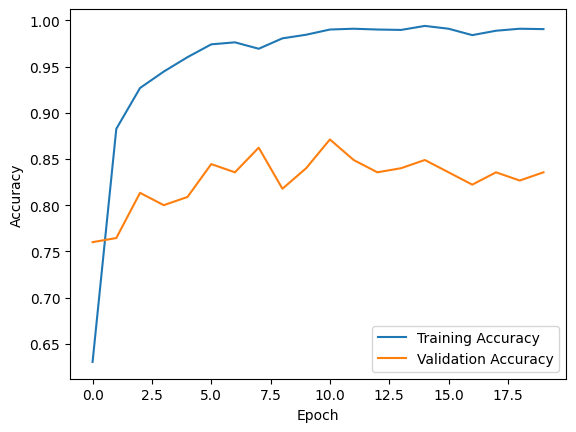

In [50]:
epoch_plot(history)

### Convolutional Blocks Analysis Plot

In [60]:
layer =  [i.name for i in model2.layers]

layer_names = ['input_2','pool1_pool', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']

1/1 [==============================] - 2s 2s/step


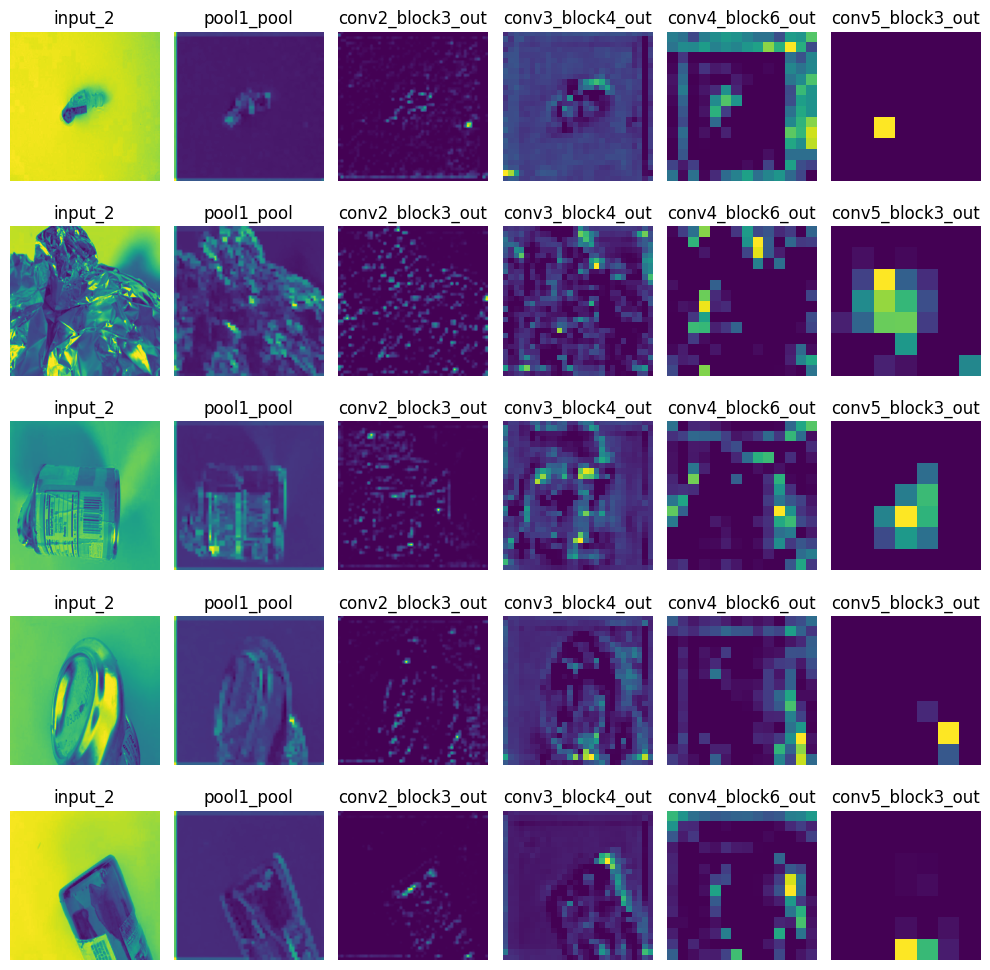

In [61]:
#Creating a new model that outputs the feature maps of the selected layers
feature_map_models = [Model(inputs=model2.input, outputs=model2.get_layer(layer_name).output) for layer_name in layer_names]

#Selecting some input samples to visualize their feature maps
sample_inputs = x_train_224[:5]  # Change this to the desired input samples

#Getting the feature maps for the selected inputs and layers
feature_maps = [feature_map_model.predict(sample_inputs) for feature_map_model in feature_map_models]

#Plotting the feature maps
num_samples = len(sample_inputs)
num_layers = len(layer_names)

fig, axes = plt.subplots(num_samples, num_layers, figsize=(10, 10))

for i in range(num_samples):
    for j in range(num_layers):
        axes[i, j].imshow(feature_maps[j][i, :, :, 0], cmap='viridis')
        axes[i, j].axis('off')
        axes[i, j].set_title(layer_names[j])

plt.tight_layout()
plt.show()